# SENG 474 A02: Assignment 3
## Lloyd's Algorithm and Hierarchical Agglomerative Clustering
Sean McAuliffe, V00913346  
March 23, 2023


(3500, 2)
(14801, 3)


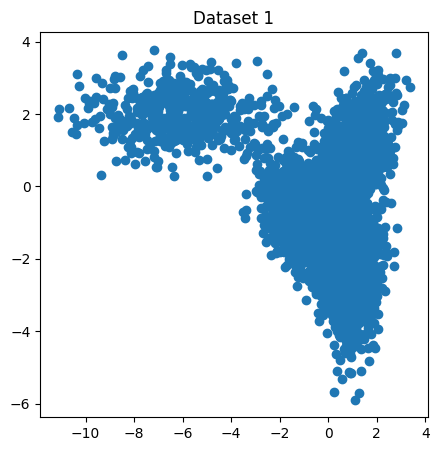

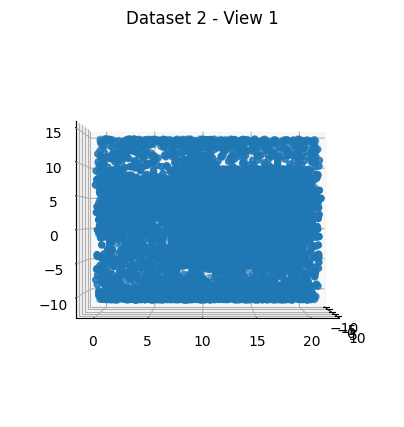

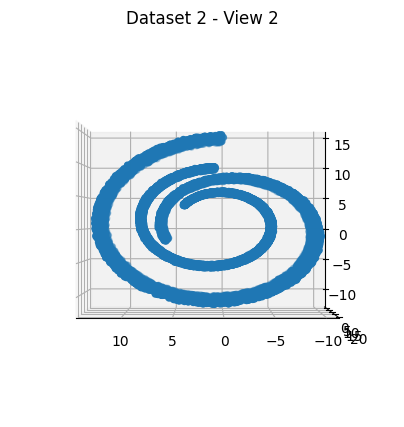

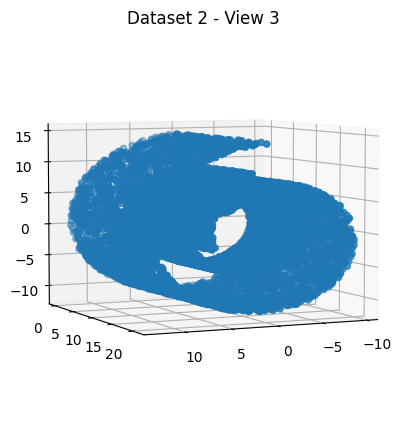

In [75]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

# Load data
dataset_1 = np.loadtxt('../data/dataset1.csv', delimiter=',')
dataset_2 = np.loadtxt('../data/dataset2.csv', delimiter=',')

print(dataset_1.shape)
print(dataset_2.shape)

# Visualize the datasets
x_1 = dataset_1[:, 0]
y_1 = dataset_1[:, 1]

x_2 = dataset_2[:, 0]
y_2 = dataset_2[:, 1]
z_2 = dataset_2[:, 2]

plt.figure(figsize=(5,5))
plt.scatter(x_1, y_1)
plt.title('Dataset 1')

fig2 = plt.figure(figsize=(5,5))
ax1 = fig2.add_subplot(111, projection='3d')
ax1.scatter(x_2, y_2, z_2)
ax1.view_init(elev=0, azim=0)
plt.title('Dataset 2 - View 1')

fig3 = plt.figure(figsize=(5,5))
ax2 = fig3.add_subplot(111, projection='3d')
ax2.scatter(x_2, y_2, z_2)
ax2.view_init(elev=0, azim=90)
plt.title('Dataset 2 - View 2')

fig4 = plt.figure(figsize=(5,5))
ax3 = fig4.add_subplot(111, projection='3d')
ax3.scatter(x_2, y_2, z_2)
ax3.view_init(elev=5, azim=65)
plt.title('Dataset 2 - View 3')

plt.show()

## Part 1: Lloyd's Algorithm
- Implement Lloyd's Algorithm for k-means clustering
- Two initialization methods:
    - Uniform Random Initialization, where each point has the same probability of
    being chosen as a cluster centre.
    - K-means++ Initialization, where the first cluster centre is chosen uniformly
    at random from the data points, and each subsequent cluster centre is chosen
    with probability proportional to the squared distance from the nearest
    cluster centre.

In [128]:
class Cluster:
    def __init__(self, centre):
        self.data = [] # includes the centre point
        self.centre = centre

    def add(self, point):
        self.data.append(point)

    def distance(self, point):
        """ Euclidian distance """
        return np.sqrt(np.sum((self.centre - point)**2))
    
    def cost(self):
        """ Sum of squared distances from centre """
        cost = 0
        for point in self.data:
            cost += self.distance(point)
        return cost
    
    def clear_data(self):
        self.data = []
    
    def __str__(self):
        return 'Cluster: centre = {}'.format(self.centre)

def total_cost(clusters):
    cost = 0
    for cluster in clusters:
        cost += cluster.cost()
    return cost

def float_equal(a, b):
    return abs(a - b) < 0.00001

def get_centres(clusters):
    """ Return a list of the cluster centres """
    return [c.centre for c in clusters]
    
def is_unique(centres, centre):
    """ Check that a cluster centre has not already been chosen """
    for c in centres:
        if c[0] == centre[0] and c[1] == centre[1]:
            return False
    return True

def all_centres_equal(previous, new):
    """ Check that the cluster centres have not changed """
    for i in range(len(previous)):
        if not float_equal(previous[i][0],new[i][0]) or not float_equal(previous[i][1], new[i][1]):
            return False
    return True

# Uniform Random Initialization, define k clusters with random centres
def init_random(X, k):
    clusters = []
    centres = []
    for i in range(k):
        # Ensure that the centres are unique
        for c in clusters:
            centres.append(c.centre)
        # Randomly choose a centre
        centre = X[np.random.randint(0, len(X))]
        while not is_unique(centres, centre):
            centre = X[np.random.randint(0, len(X))]
        centres.append(centre)
        clusters.append(Cluster(centre))
    return clusters

# K-Means++ Initialization, define k clusters with centres chosen
# with probability proportional to distance to existing clusters
def init_kmeans(X, k):
    clusters = []
    centres = []
    # Randomly choose the first centre
    centre = X[np.random.randint(0, len(X))]
    clusters.append(Cluster(centre))
    centres.append(centre)
    # Choose the remaining centres
    for i in range(1, k):
        # Compute the distance from each point to its closest centre
        # dists[0] = distance from X[0] to its closest centre
        dists = []
        for x in X:
            min_dist = np.inf
            for cluster in clusters:
                dist = cluster.distance(x)
                if dist < min_dist:
                    min_dist = dist
            dists.append(min_dist)
        # Choose the next centre with probability proportional to distance
        probability_vector = dists/np.sum(dists)
        centre = X[np.random.choice(len(X), p=probability_vector)]
        # Ensure that the centres are unique
        while not is_unique(centres, centre):
            centre = X[np.random.choice(len(X), p=probability_vector)]
        centres.append(centre)
        clusters.append(Cluster(centre))
    return clusters

# # Assign each data point to the cluster with the closest centre
def assign_to_closest(X, clusters):
    for x in X:
        min_dist = np.inf
        min_cluster = None
        for cluster in clusters:
            dist = cluster.distance(x)
            if dist < min_dist:
                min_dist = dist
                min_cluster = cluster
        min_cluster.add(x)

def lloyd(X, k, init):
    # Initialize the clusters
    C = init(X, k)
    # Repeat until the centres do not change
    previous_centres = get_centres(C)
    i = 0
    while True:
        i += 1
        # Assign each data point to the cluster with the closest centre
        for cluster in C:
            cluster.clear_data()
        assign_to_closest(X, C)
        # Update the cluster centres
        for cluster in C:
            cluster.centre = np.mean(cluster.data, axis=0)
        # Check if the centres have changed
        new_centres = get_centres(C)
        if all_centres_equal(previous_centres, new_centres):
            break
        previous_centres = new_centres
    return i, C

def plot_clusters_2d(clusters):
    for cluster in clusters:
        x = [p[0] for p in cluster.data]
        y = [p[1] for p in cluster.data]
        plt.scatter(x, y)
    plt.show()

In [ ]:
# Sanity Test of the Lloyd Algorithm
i, C = lloyd(dataset_1, 2, init_random)
print('Random: Number of iterations: {}'.format(i))
plot_clusters_2d(C)

i, C = lloyd(dataset_1, 2, init_kmeans)
print('Kmeans: Number of iterations: {}'.format(i))
plot_clusters_2d(C)

i, C = lloyd(dataset_2, 2, init_random)
print('Random: Number of iterations: {}'.format(i))
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z)
    ax.view_init(elev=0, azim=90)
plt.show()

i, C = lloyd(dataset_2, 2, init_kmeans)
print('Kmeans: Number of iterations: {}'.format(i))
fig2 = plt.figure(figsize=(5,5))
ax = fig2.add_subplot(111, projection='3d')
for cluster in C:
    x = [p[0] for p in cluster.data]
    y = [p[1] for p in cluster.data]
    z = [p[2] for p in cluster.data]
    ax.scatter(x, y, z)
    ax.view_init(elev=0, azim=90)
plt.show()

k = 2, cost = 6211.744016155597
k = 3, cost = 4668.349794689788
k = 4, cost = 3658.462357683589
k = 5, cost = 3350.6660739890167
k = 6, cost = 3115.910664793836
k = 7, cost = 2904.243415590368
k = 8, cost = 2666.2333650915866
k = 9, cost = 2544.127755758907
k = 10, cost = 2437.2741100980825
k = 11, cost = 2331.556353113114
k = 12, cost = 2235.259480718616
k = 13, cost = 2159.5905314861106
k = 14, cost = 2089.804087768183
k = 15, cost = 2021.4121742987932
k = 16, cost = 1965.0078820088581
k = 17, cost = 1908.0282423102228
k = 18, cost = 1856.8678089378734
k = 19, cost = 1811.4431630107977


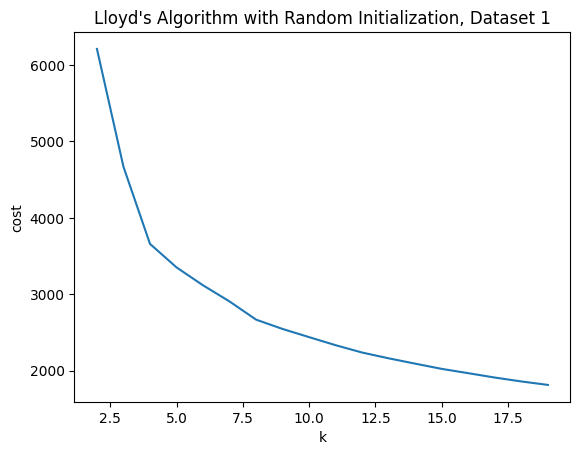

In [132]:
# Experiment 1: Lloyd's Algorithm with Random Initialization, Dataset 1

k_values = [k for k in range(2, 20)]
num_trials = 10

costs = []

for k in k_values:
    min_cost = np.inf
    chosen_clustering = None
    for i in range(num_trials):
        i, C = lloyd(dataset_1, k, init_random)
        cost = total_cost(C)
        if cost < min_cost:
            min_cost = cost
            chosen_clustering = C
    # At this point we have the best clustering for this k
    print('k = {}, cost = {}'.format(k, min_cost))
    costs.append(min_cost)

# Plot the cost as a function of k
plt.title('Lloyd\'s Algorithm with Random Initialization, Dataset 1')
plt.plot(k_values, costs)
plt.xlabel('k')
plt.ylabel('cost')
plt.show()


        